<a href="https://colab.research.google.com/github/reyndomly/goldpriceprediction/blob/main/Gold_Price_Prediction_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Reylian Prealdream Anareka

In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
gold = pd.read_csv('gold_price_data.csv')
gold['Date'] = pd.to_datetime(gold['Date'], errors='coerce')
gold.head()

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


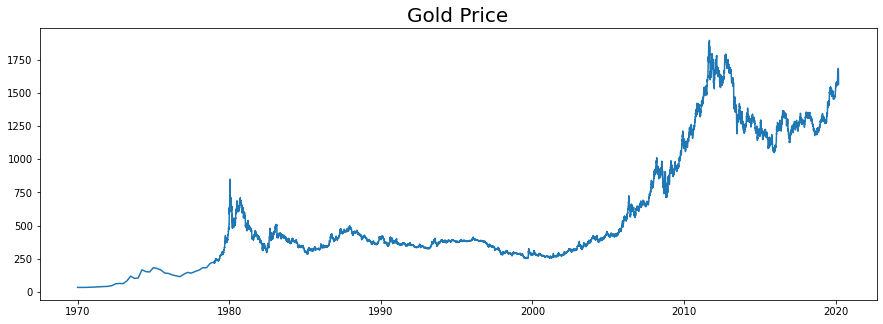

In [ ]:
dates = gold['Date'].values
temp  = gold['Value'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Gold Price',
          fontsize=20);

In [ ]:
num_data = len(gold['Value'])
train_split = 0.8

num_train = int(train_split * num_data)
num_train

8629

In [ ]:
num_val = num_data - num_train
num_val

2158

In [ ]:
train = gold[:num_train]
val = gold[num_train:]

print('Train shape: ', train.shape)
print('Validaton shape: ', val.shape)

Train shape:  (8629, 2)
Validaton shape:  (2158, 2)


In [ ]:
scaler_data = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler_data.fit_transform(gold['Value'].values.reshape(-1,1))


threshold_mae = (scaled_data.max() - scaled_data.min()) * 10/100
threshold_mae

0.1

In [ ]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(train['Value'].values.reshape(-1,1))

scaler_val = MinMaxScaler(feature_range=(0, 1))
scaled_val = scaler_val.fit_transform(val['Value'].values.reshape(-1,1))

In [ ]:
def create_dataset(dataset, look_back=30):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

X_train, Y_train = create_dataset(scaled_train)
X_test, Y_test = create_dataset(scaled_val)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
#train_set = windowed_dataset(X_train, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs=None): 
        if(logs.get('mae') < 0.03 and logs.get('val_mae') < 0.03):
          print("MAE below 10% of Data Scale, stopping training.")
          self.model.stop_training = True

callbacks=myCallback()

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='mean_absolute_error',
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(X_train,
                    Y_train,
                    epochs=100,
                    validation_data=[X_test, Y_test],
                    callbacks=[callbacks])

Epoch 1/100
269/269 [==============================] - 7s 11ms/step - loss: 0.0618 - mae: 0.0618 - val_loss: 0.0426 - val_mae: 0.0426
Epoch 2/100
269/269 [==============================] - 2s 6ms/step - loss: 0.0275 - mae: 0.0275 - val_loss: 0.0348 - val_mae: 0.0348
Epoch 3/100
269/269 [==============================] - 2s 6ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0545 - val_mae: 0.0545
Epoch 4/100
269/269 [==============================] - 2s 6ms/step - loss: 0.0231 - mae: 0.0231 - val_loss: 0.0311 - val_mae: 0.0311
Epoch 5/100
269/269 [==============================] - 2s 6ms/step - loss: 0.0218 - mae: 0.0218 - val_loss: 0.0266 - val_mae: 0.0266


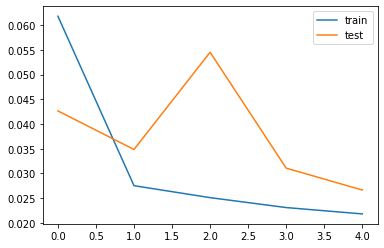

In [ ]:
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='test')
plt.legend()
plt.show()

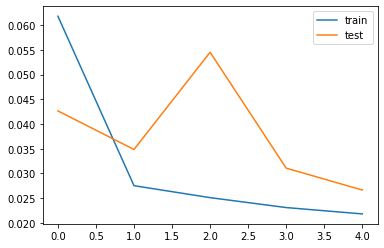

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
predicted_gold_price = model.predict(X_test)

67/67 [==============================] - 1s 2ms/step


In [ ]:
predicted_gold_price = scaler_val.inverse_transform(predicted_gold_price.reshape(-1, 1))

In [ ]:
predicted_gold_price

array([[1640.6366],
       [1642.4109],
       [1644.5471],
       ...,
       [1647.8304],
       [1650.2655],
       [1643.0834]], dtype=float32)

In [ ]:
predicted_gold_price.shape

(2128, 1)

In [ ]:
true = scaler_val.inverse_transform(Y_test.reshape(-1, 1))

In [ ]:
true.shape

(2128, 1)

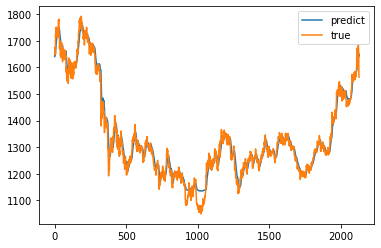

In [ ]:
plt.plot(predicted_gold_price, label='predict')
plt.plot(true, label='true')
plt.legend()
plt.show()